# Laboratorio 9: Procesamiento ECG

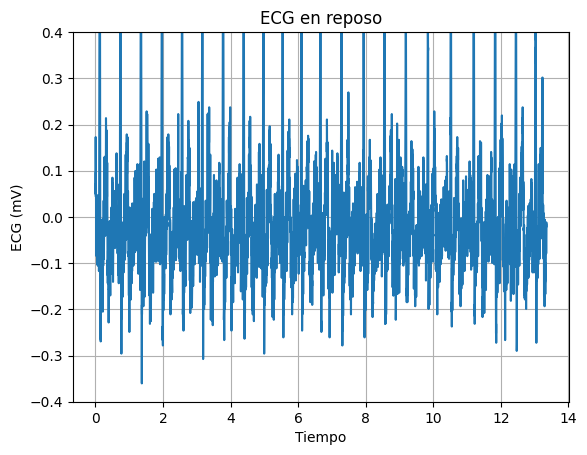

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Nombre del archivo de texto
archivo = "C:\\Users\\romin\\OneDrive\\universidad\\Séptimo ciclo\\intro a señales biomédicas\\procesamiento ECG\\data\\romi-reposo.txt"


# Leer los datos del archivo y omitir las primeras 7 líneas
datos = np.loadtxt(archivo, skiprows=7)

# Extraer la columna de interés (columna 6)
senal = datos[:, 5]

num_muestra = np.arange(len(senal))
# Conversión a V de la señal (según fórmula del Sensor user manual)
senalV = (((senal/1024)-1/2)*3.3)/1100
fs=1000
senalmV = senalV*1000
# Trazar la señal
t=num_muestra/fs
plt.plot(t, senalmV)
plt.xlabel('Tiempo')
#plt.xlim([3,5])
plt.ylim([-0.4,0.4])
plt.ylabel('ECG (mV)')
plt.title('ECG en reposo')
plt.grid(True)
plt.show()

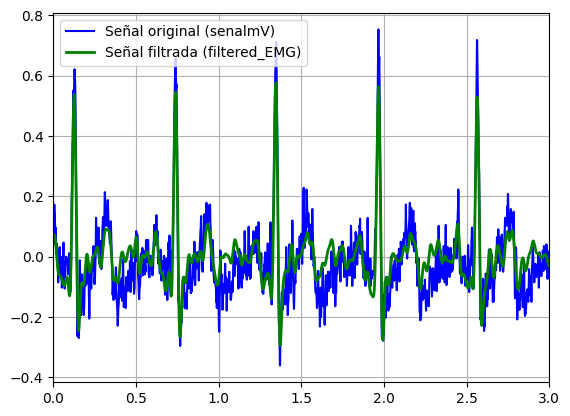

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt

# Parámetros
fs = 1000  # Frecuencia de muestreo en Hz
lowcut = 5   # Frecuencia de corte baja en Hz
highcut = 30  # Frecuencia de corte alta en Hz
order = 4  # Orden del filtro

# Diseño del filtro pasa bajas (LPF) de 35 Hz
sos_lpf = butter(order, highcut, btype='low', fs=fs, output='sos')

# Diseño del filtro pasa altas (HPF) de 5 Hz
sos_hpf = butter(order, lowcut, btype='high', fs=fs, output='sos')

# Asumiendo que `senalmV` es tu señal de entrada
# Aquí, `senalmV` debe ser un array de numpy
# Por ejemplo, senalmV = np.array([tu señal aquí])

# Generar una señal de prueba si `senalmV` no está definida (descomentar para pruebas)
# t = np.linspace(0, 1, fs, endpoint=False)
# senalmV = np.sin(2 * np.pi * 10 * t) + 0.5 * np.random.randn(t.size)

# Aplicar el filtro pasa bajas
filtered_temp = sosfiltfilt(sos_lpf, senalmV)

# Aplicar el filtro pasa altas a la señal ya filtrada
filtered_ECG = sosfiltfilt(sos_hpf, filtered_temp)

# Visualizar la señal original y la señal filtrada
plt.figure()
plt.plot(t,senalmV, 'b-', label='Señal original (senalmV)')
plt.plot(t,filtered_ECG, 'g-', linewidth=2, label='Señal filtrada (filtered_EMG)')
plt.xlim([0,3])
plt.grid()
plt.legend()
plt.show()


## Detectar picos R

### Usando findpeaks

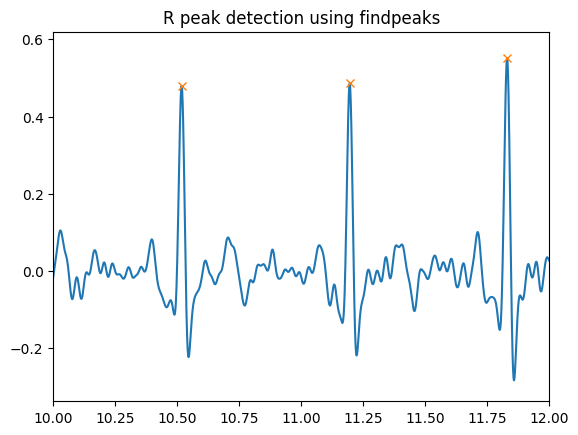

In [110]:
# Encontrar picos
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

peaks, properties = find_peaks(filtered_ECG,height=0, distance=5, prominence=0.4)

plt.plot(t, filtered_ECG)
plt.plot(t[peaks], filtered_ECG[peaks], "x")
plt.xlim([10,12])
plt.title("R peak detection using findpeaks")
plt.show()


## Usando detect r peaks de biosignalsnotebooks (Pan-Tompkins Algorithm)

In [111]:
import biosignalsnotebooks as bsnb
time_r_peaks, amplitude_r_peaks = bsnb.detect_r_peaks(filtered_ECG, fs, time_units=True, plot_result= True)

## Usando el método propuesto en "Precise detection and localization of R-peaks from ECG signals"

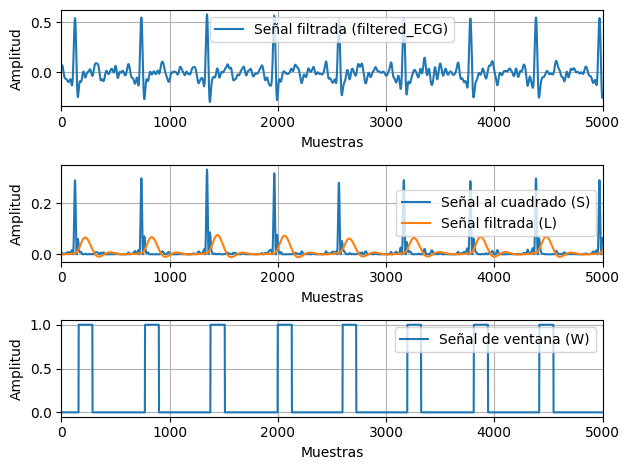

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, find_peaks, correlate

# Parámetros
fs = 1000  # Frecuencia de muestreo en Hz
lowcut = 5  # Frecuencia de corte baja en Hz para el filtro pasa bajas
order = 4  # Orden del filtro

# Diseño del filtro pasa bajas (LPF) de 5 Hz
sos_lpf = butter(order, lowcut, btype='low', fs=fs, output='sos')


# Paso 1: Calcular S(i) elevando al cuadrado la señal filtered_ECG
S = np.square(filtered_ECG)

# Paso 2: Aplicar el filtro pasa bajas de 5 Hz a S(i) para obtener L(i)
L = sosfilt(sos_lpf, S)

# Paso 3: Convertir L(i) a la señal de ventana W(i) a través del umbral dinámico
# Inicialización de W(i) y D(n)
W = np.zeros_like(L)
D = np.zeros_like(L)

# Umbral inicial (puede ajustarse según los datos específicos)
threshold = np.mean(L) + 0.5 * np.std(L)

# Cálculo del umbral dinámico y de W(i)
for n in range(1, len(L)):
    D[n] = (L[n] + D[n - 1] * (n - 1)) / n
    if L[n] >= threshold:
        W[n] = 1
    else:
        W[n] = 0

# Visualizar las señales
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(filtered_ECG, label='Señal filtrada (filtered_ECG)')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xlim([0,5000])
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(S, label='Señal al cuadrado (S)')
plt.plot(L, label='Señal filtrada (L)')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xlim([0,5000])
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(W, label='Señal de ventana (W)')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.xlim([0,5000])
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


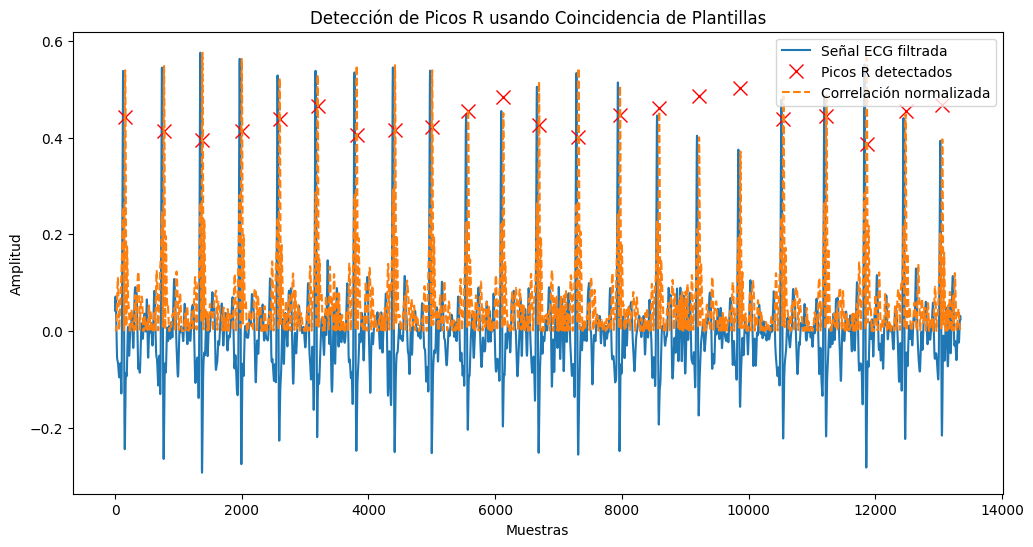

In [113]:
# Encuentra los inicios y finales de los complejos QRS
inicios = np.where(np.diff(W.astype(int)) == 1)[0] + 1  # +1 para compensar el desfase de diff
finales = np.where(np.diff(W.astype(int)) == -1)[0]

if finales[0] < inicios[0]:
    finales = finales[1:]  # Asegurar que el primer final tenga un inicio correspondiente

# Extraer la plantilla QRS si es posible
if len(inicios) > 0 and len(finales) > 0:
    QRS_segment = filtered_ECG[inicios[0]:finales[0]]
    peak_idx = np.argmax(np.abs(QRS_segment)) + inicios[0]
    window_width = 60
    QRS_template = filtered_ECG[peak_idx - window_width:peak_idx + window_width]
else:
    QRS_template = np.array([])  # Manejo de caso sin detección

# Normalizar la plantilla
if len(QRS_template) > 0:
    QRS_template = (QRS_template - np.mean(QRS_template)) / np.std(QRS_template)

    # Correlación cruzada para encontrar coincidencias de la plantilla
    correlation = correlate(filtered_ECG, QRS_template, mode='same')
    correlation = np.abs(correlation)

    # Detectar picos en la señal de correlación que superen un umbral adaptativo
    peak_indices, _ = find_peaks(correlation, height=np.max(correlation) * 0.5, distance=50)

    # Visualización de los resultados
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_ECG, label='Señal ECG filtrada')
    offset = np.max(filtered_ECG) * 1.1
    plt.plot(peak_indices, filtered_ECG[peak_indices] + offset, 'rx', label='Picos R detectados', markersize=10)
    plt.plot(np.arange(len(correlation)), correlation / np.max(correlation) * np.max(filtered_ECG),
             label='Correlación normalizada', linestyle='--')
    plt.title('Detección de Picos R usando Coincidencia de Plantillas')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.show()
else:
    print("No se encontró una plantilla QRS válida para realizar la coincidencia de plantillas.")



## Extracción de características usando una Transformada de Wavelet Discreta, con una wavelet Daubechies 2 con un nivel de descomposición de 6, como se sugiere en "Feature Extraction on Multi-Channel ECG Signals using Daubechies Wavelet Algorithm "

In [114]:
import pywt

# Realizar la descomposición en wavelets
coeffs = pywt.wavedec(filtered_ECG, 'db2', level=6)

for i, c in enumerate(coeffs):
    rms = np.sqrt(np.mean(np.square(c)))
    min_val = np.min(c)
    max_val = np.max(c)
    median_val = np.median(c)
    std_dev = np.std(c)

# Calcular estadísticas totales considerando todas las componentes wavelet
all_coeffs = np.concatenate(coeffs)

rms_total = np.sqrt(np.mean(np.square(all_coeffs)))
min_total = np.min(all_coeffs)
max_total = np.max(all_coeffs)
median_total = np.median(all_coeffs)
std_dev_total = np.std(all_coeffs)

print("Características de la señal ECG:")
print(f"  RMS: {rms_total}")
print(f"  Min: {min_total}")
print(f"  Max: {max_total}")
print(f"  Median: {median_total}")
print(f"  Std Dev: {std_dev_total}")

Características de la señal ECG:
  RMS: 0.1011536638937019
  Min: -1.4990100631721928
  Max: 2.133273947601097
  Median: 1.4162015816616969e-06
  Std Dev: 0.10115229496986558


## HRV (Distancia entre picos R)

In [115]:
# Calcular las diferencias entre tiempos adyacentes
r_peak_differences = np.diff(time_r_peaks)

# Calcular el valor promedio de las distancias entre picos R
average_r_peak_distance = np.mean(r_peak_differences)

# Mostrar las diferencias y el valor promedio
print("Distancia promedio entre picos R (HRV):", average_r_peak_distance)

Distancia promedio entre picos R (HRV): 0.6142365002051776


## A partir del HRV podemos calcular el pulso cardíaco (BPM) 

In [116]:
BPM = (60/average_r_peak_distance)
print("Pulso cardíaco (BPM):", BPM)

Pulso cardíaco (BPM): 97.68224450998564


## Referencias
### 1. D. Zhai et al., «Precise detection and localization of R-peaks from ECG signals», MBE, vol. 20, n.º 11, Art. n.º mbe-20-11-848, 2023, doi: 10.3934/mbe.2023848.
### 2. «Feature Extraction on Multi-Channel ECG Signals using Daubechies Wavelet Algorithm | IEEE Conference Publication | IEEE Xplore». Accedido: 7 de junio de 2024. [En línea]. Disponible en: https://ieeexplore.ieee.org/document/10038238
